In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import bernoulli
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from utils import make_all_dot_product_features_df,make_dot_product_features, make_all_embedding_difference_features_df

In [48]:
data_path = '/home/jolteon/eluvio_challenge/data/train/tt0052357.pkl'


with open(data_path, 'rb') as f:
    data = pickle.load(f)

In [49]:
data.keys()

dict_keys(['place', 'cast', 'action', 'audio', 'scene_transition_boundary_ground_truth', 'shot_end_frame', 'scene_transition_boundary_prediction', 'imdb_id'])

Shot-level: four features, preprocessed and encoded as 2D tensors

    place: num x 2048
    cast: num x 512,
    action: num x 512
    audio: num x 512


Scene-level:
 Ground truth (‘scene_transition_boundary_ground_truth’) is a boolean vector
labeling scene transition boundaries.
b. Preliminary scene transition prediction (‘scene_transition_boundary_prediction’)
is a prediction template, meaning your final output should resemble the format
and calculate the probability of a shot boundary being a scene boundary, i.e.
- 1 -
contain one score (between 0 and 1) for each shot transition. You’re also
welcome to utilize the preliminary results for your predictions.
c. The 'shot_end_frame' is the end frame index for each shot, which is provided for
evaluation only.



In [35]:
data['scene_transition_boundary_ground_truth'].shape

torch.Size([1100])

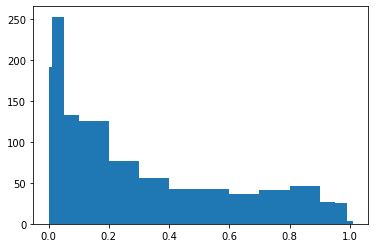

In [36]:
plt.hist(data['scene_transition_boundary_prediction'].numpy(),bins=[0,0.01,0.05,0.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99,1.01])
plt.show()

In [37]:
[0,0.01,0.05,0.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99,1.01]

[0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.01]

In [38]:
data['shot_end_frame'].shape

torch.Size([1101])

In [39]:
data['place'].shape

torch.Size([1101, 2048])

In [40]:
data['scene_transition_boundary_ground_truth'].numpy().astype(int)

array([0, 0, 0, ..., 0, 0, 1])

In [41]:
scene_boundary_truth = data['scene_transition_boundary_ground_truth'].numpy().astype(int)
place_embedding = data['place'].numpy()
cast_embedding = data['cast'].numpy()
action_embedding = data['action'].numpy()
audio_embedding = data['audio'].numpy()


In [42]:
scene_boundary_truth.shape[0]

1100

# Random Forest Boundary detection

In [50]:
train_dir = '/home/jolteon/eluvio_challenge/data/train/'
val_dir = '/home/jolteon/eluvio_challenge/data/val/'
test_dir = '/home/jolteon/eluvio_challenge/data/test/'

In [58]:
data_train = make_all_dot_product_features_df(train_dir)
data_val =  make_all_dot_product_features_df(test_dir)
#Combine, since we are going to do crossval
data_train = pd.concat([data_train,data_val])
#seperate X,y
X_train = data_train[['place_dp','cast_dp','action_dp','audio_dp']]
y_train = data_train['boundary_truth']

48
8


In [59]:
data_train

,place_dp,cast_dp,action_dp,audio_dp,boundary_truth
0,91.192154,0.000000,0.000000,0.584730,0
1,489.716553,0.000000,0.000000,0.231411,0
2,445.407837,0.000000,0.000000,0.364196,0
3,292.007690,0.000000,0.000000,0.850917,0
4,350.747498,0.000000,0.000000,0.737919,0
...,...,...,...,...,...
1868,465.193115,1.518258,4138.864258,0.256540,1
1869,346.203339,0.560668,2765.230713,0.594189,1
1870,265.108948,0.575942,2732.739258,0.731078,1
1871,286.565979,0.641870,3133.891602,0.502469,0


### Random forest/Logisitc Grid on dot product features

In [101]:
#%%time
#param_grid = {'n_estimators': [500],
#              'min_samples_leaf': [100,50,10],
#              'max_depth': [10,15,20,25,30],
#             }
#clf = GridSearchCV(
#        RandomForestClassifier(),param_grid,scoring='average_precision',n_jobs=4)
#clf.fit(X_train, y_train)                 


CPU times: user 1min 2s, sys: 251 ms, total: 1min 3s
Wall time: 21min 57s


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_leaf': [100, 50, 10],
                         'n_estimators': [500]},
             scoring='average_precision')

Fitting an RF model takes approximately 1 minute per model

In [111]:
%%time
param_grid = {'C' : [.0001,.001,.01,.1,.1,10,100]
             }
clf = GridSearchCV(
        LogisticRegression(),param_grid,scoring='average_precision',n_jobs=4)
clf.fit(X_train, y_train)                 


CPU times: user 379 ms, sys: 141 ms, total: 520 ms
Wall time: 3.05 s


GridSearchCV(estimator=LogisticRegression(), n_jobs=4,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 0.1, 10, 100]},
             scoring='average_precision')

Fitting an Logistic model is extremely fast

In [112]:
clf.cv_results_

{'mean_fit_time': array([0.21675997, 0.19524693, 0.19588537, 0.21763601, 0.21203732,
        0.1893826 , 0.18527846]),
 'std_fit_time': array([0.03485587, 0.04589468, 0.0646747 , 0.06798589, 0.04875244,
        0.03981532, 0.04223883]),
 'mean_score_time': array([0.00563293, 0.00579257, 0.00636811, 0.00599527, 0.00565615,
        0.00563054, 0.00535917]),
 'std_score_time': array([0.00033247, 0.00067348, 0.00072163, 0.00090026, 0.00021436,
        0.000182  , 0.0002019 ]),
 'param_C': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 0.1, 10, 100],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 0.1},
  {'C': 10},
  {'C': 100}],
 'split0_test_score': array([0.13326722, 0.13751316, 0.14066426, 0.14109236, 0.14109236,
        0.14113692, 0.1411376 ]),
 'split1_test_score': array([0.13501104, 0.14443349, 0.14654727, 0.14638424, 0.14638424,
  

In [103]:

best_model = clf.best_estimator_

In [104]:
best_model

RandomForestClassifier(max_depth=10, min_samples_leaf=100, n_estimators=500)

# Random Forest / Logistic Regression on difference of embeddings features

In [125]:
train_dir = '/home/jolteon/eluvio_challenge/data/train/'
val_dir = '/home/jolteon/eluvio_challenge/data/val/'
test_dir = '/home/jolteon/eluvio_challenge/data/test/'

In [139]:
X_train,y_train= make_all_embedding_difference_features_df(train_dir)
X_val,y_val =  make_all_embedding_difference_features_df(test_dir)
#Combine, since we are going to do crossval
#data_train = pd.concat([data_train,data_val])
#seperate X,y
X = np.vstack([X_train,X_val])
y = np.concatenate([y_train,y_val])


In [140]:
print(X.shape)
print(y.shape)

(93539, 3584)
(93539,)


In [145]:
%%time
#param_grid = {'C' : [.0001,.001,.01,.1,.1,10,100]
#             }
param_grid = {'C' : [1]
             }
clf = GridSearchCV(
        LogisticRegression(),param_grid,scoring='average_precision')
clf.fit(X, y)                 


/home/jolteon/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jolteon/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

CPU times: user 2min 15s, sys: 5.82 s, total: 2min 21s
Wall time: 2min 24s


/home/jolteon/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(estimator=LogisticRegression(), param_grid={'C': [1]},
             scoring='average_precision')

In [146]:
clf.cv_results_

{'mean_fit_time': array([22.97734632]),
 'std_fit_time': array([1.3481681]),
 'mean_score_time': array([0.24742317]),
 'std_score_time': array([0.03400968]),
 'param_C': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1}],
 'split0_test_score': array([0.11180202]),
 'split1_test_score': array([0.10383492]),
 'split2_test_score': array([0.10508855]),
 'split3_test_score': array([0.10298367]),
 'split4_test_score': array([0.10233287]),
 'mean_test_score': array([0.1052084]),
 'std_test_score': array([0.00342329]),
 'rank_test_score': array([1], dtype=int32)}

In [ ]:
best_model = clf.best_estimator_

# Prediction code

In [113]:
dir_to_save = '/home/jolteon/eluvio_challenge/baseline_dot_product'
#best_model
for file in os.listdir(test_dir):
    if file.endswith('.pkl'):
        with open(test_dir+file, 'rb') as f:
            data = pickle.load(f)
        df = make_dot_product_features(data)
        X = df['place_dp','cast_dp','action_dp','audio_dp']
        predictions = best_model.predict_proba(X)[:,1]
        data_to_pkl={}
        data_to_pkl['scene_transition_boundary_ground_truth'] = \
            data['scene_transition_boundary_ground_truth'].numpy().astype(float)
        data_to_pkl['scene_transition_boundary_prediction'] = \
            predictions
        data_to_pkl['shot_end_frame'] = data['shot_end_frame']
        data_to_pkl['imdb_id'] = file[:-4]

        with open(dir_to_save+file, 'wb') as f:
            pickle.dump(data_to_pkl,f)
                
    break

In [116]:
best_model.predict_proba(df[['place_dp','cast_dp','action_dp','audio_dp']])[:,1]

array([0.1981855 , 0.18860701, 0.08471412, ..., 0.02488697, 0.04490552,
       0.15358644])

In [80]:
df['prediction'] = best_model.predict_proba(df[['place_dp','cast_dp','action_dp','audio_dp']])

In [81]:
df['boundary_truth'].sum()

132

In [82]:
df['prediction'].sum()

2188.5682480466207

In [83]:
df['prediction']

0       0.805527
1       0.811739
2       0.917920
3       0.926434
4       0.914055
          ...   
2390    0.941737
2391    0.967304
2392    0.973902
2393    0.950620
2394    0.851580
Name: prediction, Length: 2395, dtype: float64

In [84]:
best_model.predict_proba(df[['place_dp','cast_dp','action_dp','audio_dp']])

array([[0.80552714, 0.19447286],
       [0.81173921, 0.18826079],
       [0.91792041, 0.08207959],
       ...,
       [0.97390155, 0.02609845],
       [0.95062027, 0.04937973],
       [0.85158004, 0.14841996]])

In [87]:
df

,place_dp,cast_dp,action_dp,audio_dp,boundary_truth
0,118.424072,0.000000,0.000000,0.434202,0
1,157.870056,0.000000,0.000000,0.111475,0
2,127.724617,0.778729,3500.740723,0.336267,0
3,165.181152,0.835795,3623.486328,0.344319,0
4,106.931419,0.733072,3769.134033,0.181464,0
...,...,...,...,...,...
2390,405.716431,0.726916,3841.790283,0.540637,0
2391,515.628113,0.770968,3770.466309,0.875773,0
2392,458.387207,0.739174,4242.908203,0.892689,0
2393,369.912415,0.596361,5012.264160,0.356102,0


# Scratchwork Below

In [ ]:
# Loading the Digits dataset
digits = datasets.load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

In [95]:
!python3 evaluate_sceneseg.py baseline_random/

# of IMDB IDs: 64
Scores: {
    "AP": 0.0767715899777535,
    "mAP": 0.08082663001958115,
    "Miou": 0.2977235355218801,
    "Precision": 0.08384742911615159,
    "Recall": 0.0835096507178984,
    "F1": 0.08012348697903306
}


In [100]:
!python3 evaluate_sceneseg.py baseline_preliminary

# of IMDB IDs: 8
Scores: {
    "AP": 0.4799354967433886,
    "mAP": 0.49328420987394367,
    "Miou": 0.4797450602748557,
    "Precision": 0.3380879775551314,
    "Recall": 0.6925031762816138,
    "F1": 0.44427621620186347
}


In [99]:
!python3 make_baseline.py